# Análise de Valorização Imobiliária Real por Tipo de Uso

Este notebook analisa a valorização real dos imóveis ao longo do tempo, calculando taxas de crescimento anual para diferentes tipos de uso em São Paulo.

**Objetivos principais:**
- Calcular taxa de valorização anual real para cada imóvel individual
- Identificar tipos de uso com maior e menor valorização
- Aplicar critérios estatísticos rigorosos para análise confiável
- Excluir outliers por tipo de uso usando método IQR
- Gerar análises temporais e comparativas por tipo de uso

**Metodologia Corrigida:**
1. **Cálculo de Taxa de Valorização Individual**: Regressão linear no log dos valores venais ao longo do tempo para cada imóvel
2. **Critério de Significância**: Pelo menos 100 amostras em 4 dos 6 anos por tipo de uso
3. **Exclusão de Outliers**: Método IQR aplicado separadamente para cada tipo de uso
4. **Análise Estatística**: Testes de significância e correlações para validar resultados
5. **Agrupamento por Tipo**: Estatísticas agregadas e comparações entre tipos de uso

**Dados:**
- ITBI: Transações imobiliárias (2019-2024)
- IPTU: Valores venais estimados pela Prefeitura (2019-2024)

**Resultado**: Taxa de valorização anual real por tipo de uso do imóvel, não apenas divergências entre estimativas.


## 1. Importação de Bibliotecas


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

# Configurações
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Bibliotecas importadas com sucesso!')


✅ Bibliotecas importadas com sucesso!


## 2. Carregamento dos Dados


In [ ]:
# Definir caminhos dos arquivos
data_path = 'data/'
iptu_file = data_path + 'IPTU_2019_2024_VV.csv'
itbi_file = data_path + 'ITBI_2019_2024_v2.csv'  # Versão com dados geográficos

print('Carregando dados...')
print(f'Arquivo IPTU: {iptu_file}')
print(f'Arquivo ITBI: {itbi_file}')

try:
    df_itbi = pd.read_csv(itbi_file, encoding='utf-8', low_memory=False)
    print(f'\\n✅ Dados ITBI carregados: {df_itbi.shape[0]:,} registros e {df_itbi.shape[1]} colunas')
    
    df_iptu = pd.read_csv(iptu_file, encoding='utf-8', low_memory=False)
    print(f'✅ Dados IPTU carregados: {df_iptu.shape[0]:,} registros e {df_iptu.shape[1]} colunas')
except Exception as e:
    print(f'Erro ao carregar: {e}')
    try:
        print('Tentando com encoding latin-1...')
        df_itbi = pd.read_csv(itbi_file, encoding='latin-1', low_memory=False)
        df_iptu = pd.read_csv(iptu_file, encoding='latin-1', low_memory=False)
        print(f'✅ Dados carregados com sucesso!')
    except:
        print('Erro ao carregar com diferentes encodings')

print('\\n🎉 Carregamento concluído!')


Carregando dados...
Arquivo IPTU: data/IPTU_2019_2024_VV.csv
Arquivo ITBI: data/ITBI_2019_2024_v2.csv
\n✅ Dados ITBI carregados: 941,623 registros e 18 colunas


## 3. Preparação dos Dados para Análise

Esta seção realiza:
1. **Filtros ITBI**: Apenas registros com `Proporção Transmitida (%) > 1`
2. **Cálculo VALOR REAL**: Reversão da proporção transmitida para obter valor total
3. **Merge 1:N**: Junção de ITBI com IPTU usando número do cadastro + ano
4. **Preparação para análise temporal**: Dados organizados para cálculo de valorização por imóvel


In [ ]:
# ============================================================================
# 3. PREPARAÇÃO DOS DADOS PARA ANÁLISE
# ============================================================================

print('='*80)
print('3. PREPARAÇÃO DOS DADOS PARA ANÁLISE'.center(80))
print('='*80)

# 3.1. Filtros e Preparação dos Dados ITBI
print('\n📋 3.1. FILTROS E PREPARAÇÃO DOS DADOS ITBI\n')

# Verificar colunas disponíveis
print('📋 Colunas disponíveis no ITBI:')
for i, col in enumerate(df_itbi.columns):
    print(f'   {i+1:2d}. {col}')

required_cols = ['Proporção Transmitida (%)', 'Base de Cálculo adotada', 
                 'N° do Cadastro (SQL)', 'Ano da Transacao']
if not all(col in df_itbi.columns for col in required_cols):
    print('❌ Colunas necessárias não encontradas!')
else:
    print('✅ Todas as colunas necessárias encontradas no ITBI')
    
    # Filtro 1: Proporção Transmitida (%) = 100
    print('\n🔹 Aplicando filtro: Proporção Transmitida (%) = 100...')
    count_before = len(df_itbi)
    df_itbi_filtered = df_itbi[df_itbi['Proporção Transmitida (%)'] == 100].copy()
    print(f'   Registros antes: {count_before:,}')
    print(f'   Registros após: {len(df_itbi_filtered):,}')
    print(f'   Registros removidos: {count_before - len(df_itbi_filtered):,} ({(count_before - len(df_itbi_filtered))/count_before*100:.2f}%)')
    
    # Cálculo VALOR REAL (quando proporção = 100, valor real = base de cálculo)
    print('\n🔹 Calculando VALOR REAL...')
    #df_itbi_filtered['VALOR REAL'] = df_itbi_filtered['Base de Cálculo adotada'].copy()
    df_itbi_filtered['VALOR REAL'] = df_itbi_filtered.apply(lambda row: row['Base de Cálculo adotada'] / row['Proporção Transmitida (%)'] * 100, axis=1)
    df_itbi_filtered = df_itbi_filtered[df_itbi_filtered['VALOR REAL'] > 1]
    
    # Verificar se existe coluna 'Valor Venal de Referência' para aplicar filtro adicional
    if 'Valor Venal de Referência' in df_itbi_filtered.columns:
        print('\n🔹 Aplicando filtro adicional: Valor Venal de Referência > 1...')
        count_before_venal = len(df_itbi_filtered)
        df_itbi_filtered = df_itbi_filtered[df_itbi_filtered['Valor Venal de Referência'] > 1].copy()
        print(f'   Registros antes: {count_before_venal:,}')
        print(f'   Registros após: {len(df_itbi_filtered):,}')
        print(f'   Registros removidos: {count_before_venal - len(df_itbi_filtered):,} ({(count_before_venal - len(df_itbi_filtered))/count_before_venal*100:.2f}%)')
    else:
        print('\n⚠️ Coluna "Valor Venal de Referência" não encontrada. Aplicando apenas filtro VALOR REAL > 1...')
    
    # Filtro 2: VALOR REAL > 1
    count_before_valor = len(df_itbi_filtered)
    df_itbi_filtered = df_itbi_filtered[df_itbi_filtered['VALOR REAL'] > 1].copy()
    print(f'\n   Registros antes: {count_before_valor:,}')
    print(f'   Registros após: {len(df_itbi_filtered):,}')
    
    # Estatísticas
    print(f'\n📊 ESTATÍSTICAS DO VALOR REAL:')
    print(f'   Total: {len(df_itbi_filtered):,}')
    print(f'   Mínimo: R$ {df_itbi_filtered["VALOR REAL"].min():,.2f}')
    print(f'   Máximo: R$ {df_itbi_filtered["VALOR REAL"].max():,.2f}')
    print(f'   Médio: R$ {df_itbi_filtered["VALOR REAL"].mean():,.2f}')
    print(f'   Mediano: R$ {df_itbi_filtered["VALOR REAL"].median():,.2f}')

# 3.2. Preparação IPTU
print('\n📋 3.2. PREPARAÇÃO DOS DADOS IPTU\n')

if 'VALOR VENAL' in df_iptu.columns:
    df_iptu['VALOR VENAL'] = pd.to_numeric(df_iptu['VALOR VENAL'], errors='coerce')
    df_iptu_filtered = df_iptu[df_iptu['VALOR VENAL'].notna() & (df_iptu['VALOR VENAL'] > 0)].copy()
    print('✅ VALOR VENAL processado')
    print(f'   Total: {len(df_iptu_filtered):,}')
    print(f'   Mínimo: R$ {df_iptu_filtered["VALOR VENAL"].min():,.2f}')
    print(f'   Máximo: R$ {df_iptu_filtered["VALOR VENAL"].max():,.2f}')
    print(f'   Médio: R$ {df_iptu_filtered["VALOR VENAL"].mean():,.2f}')
else:
    print('❌ VALOR VENAL não encontrado!')
    df_iptu_filtered = df_iptu.copy()

# 3.3. Merge 1:N
print('\n📋 3.3. REALIZAÇÃO DO MERGE 1:N\n')

# Converter para string
df_itbi_filtered['N° do Cadastro (SQL)'] = df_itbi_filtered['N° do Cadastro (SQL)'].astype(str)
df_itbi_filtered['Ano da Transacao'] = df_itbi_filtered['Ano da Transacao'].astype(str)

df_iptu_filtered['NUMERO DO CONTRIBUINTE'] = df_iptu_filtered['NUMERO DO CONTRIBUINTE'].astype(str)
df_iptu_filtered['ANO DO EXERCICIO'] = df_iptu_filtered['ANO DO EXERCICIO'].astype(str)

print('🔄 Realizando merge...')
print(f'   ITBI: {len(df_itbi_filtered):,}')
print(f'   IPTU: {len(df_iptu_filtered):,}')

df_merged = pd.merge(
    df_itbi_filtered,
    df_iptu_filtered,
    left_on=['N° do Cadastro (SQL)', 'Ano da Transacao'],
    right_on=['NUMERO DO CONTRIBUINTE', 'ANO DO EXERCICIO'],
    how='inner',
    suffixes=('_ITBI', '_IPTU')
)

print(f'\n✅ Merge: {len(df_merged):,} registros')

# Limpeza
df_merged_clean = df_merged[
    df_merged['VALOR REAL'].notna() & 
    df_merged['VALOR VENAL'].notna() &
    (df_merged['VALOR REAL'] > 0) &
    (df_merged['VALOR VENAL'] > 0)
].copy()

print(f'   Após limpeza: {len(df_merged_clean):,} registros')

print('\n' + '='*80)
print('✅ DATASET PREPARADO PARA ANÁLISE DE VALORIZAÇÃO!'.center(80))
print('='*80)


                      3. PREPARAÇÃO DOS DADOS PARA ANÁLISE                      

📋 3.1. FILTROS E PREPARAÇÃO DOS DADOS ITBI

✅ Todas as colunas necessárias encontradas no ITBI

🔹 Aplicando filtro: Proporção Transmitida (%) > 1...
   Registros antes: 941,623
   Registros após: 707,205
   Registros removidos: 234,418 (24.90%)

🔹 Calculando VALOR REAL...

   Registros antes: 707,205
   Registros após: 702,204

📊 ESTATÍSTICAS DO VALOR REAL:
   Total: 702,204
   Mínimo: R$ 1.53
   Máximo: R$ 4,672,413,793.10
   Médio: R$ 2,034,946.18
   Mediano: R$ 427,000.00

📋 3.2. PREPARAÇÃO DOS DADOS IPTU

✅ VALOR VENAL processado
   Total: 21,317,311
   Mínimo: R$ 78.01
   Máximo: R$ 4,861,333,058.59
   Médio: R$ 437,341.05

📋 3.3. REALIZAÇÃO DO MERGE 1:N

🔄 Realizando merge...
   ITBI: 702,204
   IPTU: 21,317,311

✅ Merge: 670,267 registros
   Após limpeza: 670,267 registros

                ✅ DATASET PREPARADO PARA ANÁLISE DE VALORIZAÇÃO!                


In [ ]:
# Verificar estrutura dos dados preparados
print('📊 ESTRUTURA DOS DADOS PREPARADOS:')
print(f'Total de registros: {len(df_merged_clean):,}')
print(f'Imóveis únicos: {df_merged_clean["N° do Cadastro (SQL)"].nunique():,}')
print(f'Anos disponíveis: {sorted(df_merged_clean["Ano da Transacao"].unique())}')
print(f'Tipos de uso: {df_merged_clean["TIPO DE USO DO IMOVEL"].nunique()}')

# Mostrar primeiras linhas
print('\n📋 PRIMEIRAS LINHAS DO DATASET:')
display(df_merged_clean.head())

📊 ESTRUTURA DOS DADOS PREPARADOS:
Total de registros: 670,267
Imóveis únicos: 558,025
Anos disponíveis: ['2019', '2020', '2021', '2022', '2023', '2024']
Tipos de uso: 37

📋 PRIMEIRAS LINHAS DO DATASET:


,N° do Cadastro (SQL),Natureza de Transação,Valor de Transação (declarado pelo contribuinte),Data de Transação,Valor Venal de Referência,Proporção Transmitida (%),Valor Venal de Referência (proporcional),Base de Cálculo adotada,Tipo de Financiamento,Valor Financiado,Situação do SQL,Ano da Transacao,Mes da Transacao,Ano/Mes da Transacao,setor,quadra,lote,bairro,VALOR REAL,NUMERO DO CONTRIBUINTE,ANO DO EXERCICIO,NOME DE LOGRADOURO DO IMOVEL,NUMERO DO IMOVEL,AREA DO TERRENO,AREA CONSTRUIDA,AREA OCUPADA,VALOR DO M2 DO TERRENO,VALOR DO M2 DE CONSTRUCAO,TIPO DE USO DO IMOVEL,TIPO DE PADRAO DA CONSTRUCAO,VALOR VENAL
0,12310100659,1.Compra e venda,900000.00,2019-01-02,773836.0,100.0,773836.0,900000.0,1.Sistema Financeiro de Habitação,400000.00,Ativo Predial,2019,1,2019/01,123,101,65,JARDIM LEONOR,900000.0,12310100659,2019,R FRANCISCO PRETO,46.0,49139.0,246.0,35645.0,1629,1854,Apartamento em condomínio,Residencial vertical - padrão D,532585.651680
1,5528502403,1.Compra e venda,420000.00,2019-01-02,303832.0,100.0,303832.0,420000.0,1.Sistema Financeiro de Habitação,340721.07,Ativo Predial,2019,1,2019/01,55,285,240,VL FORMOSA,420000.0,5528502403,2019,R PRETORIA,437.0,5152.0,109.0,3862.0,1468,1607,Apartamento em condomínio,Residencial vertical - padrão C,215205.380546
2,29903601032,1.Compra e venda,650000.00,2019-01-03,459364.0,100.0,459364.0,650000.0,NaN,0.00,Ativo Predial,2019,1,2019/01,299,36,103,VILA OLIMPIA,650000.0,29903601032,2019,R MIN JESUINO CARDOSO,148.0,1886.0,98.0,1432.0,4969,2139,Apartamento em condomínio,Residencial vertical - padrão C,319984.188000
3,4201104559,1.Compra e venda,61765.36,2019-01-03,300840.0,100.0,300840.0,300840.0,NaN,0.00,Ativo Predial,2019,1,2019/01,42,11,455,SAUDE,300840.0,4201104559,2019,R AFONSO CELSO,171.0,1968.0,84.0,1521.0,2223,2139,Apartamento em condomínio,Residencial vertical - padrão C,206303.522216
4,2206602970,1.Compra e venda,965000.00,2019-01-03,575501.0,100.0,575501.0,965000.0,NaN,0.00,Ativo Predial,2019,1,2019/01,22,66,297,PERDIZES,965000.0,2206602970,2019,R COTOXO,637.0,1548.0,172.0,1548.0,2908,2139,Apartamento em condomínio,Residencial vertical - padrão C,392974.116036


### 📚 Por que usar Regressão Linear no Log dos Valores?

A metodologia utiliza **regressão linear no logaritmo dos valores** para calcular a taxa de valorização. Esta escolha é fundamentada em várias razões teóricas e práticas:

#### 1. **Modelagem de Crescimento Exponencial**

Preços imobiliários geralmente crescem a uma **taxa percentual constante** ao longo do tempo, seguindo um padrão exponencial:

\[
V(t) = V_0 \times (1 + r)^t
\]

onde:
- \(V(t)\) = valor no tempo \(t\)
- \(V_0\) = valor inicial
- \(r\) = taxa de crescimento anual
- \(t\) = tempo em anos

Aplicando logaritmo natural:
\[
\ln(V(t)) = \ln(V_0) + \ln(1 + r) \times t
\]

Isso transforma o crescimento exponencial em uma relação **linear** entre \(\ln(V)\) e \(t\), permitindo usar regressão linear simples.

#### 2. **Interpretação Direta do Coeficiente**

No modelo log-linear:
\[
\log(V) = \beta_0 + \beta_1 \times \text{ano}
\]

O coeficiente \(\beta_1\) representa aproximadamente a **taxa de crescimento anual percentual**:
\[
\text{Taxa anual} \approx (e^{\beta_1} - 1) \times 100\%
\]

#### 3. **Estabilização da Variância (Homocedasticidade)**

Valores maiores tendem a ter maior variabilidade (heterocedasticidade). A transformação logarítmica estabiliza a variância, atendendo melhor às premissas da regressão linear.

#### 4. **Distribuição dos Resíduos**

Preços imobiliários frequentemente apresentam distribuição assimétrica (positivamente enviesada). O log ajuda a aproximar os resíduos de uma distribuição normal, melhorando a inferência estatística.

#### 5. **Linearização de Relações Multiplicativas**

A transformação logarítmica converte relações multiplicativas em aditivas, simplificando o modelo e tornando os efeitos mais interpretáveis.

#### 6. **Robustez a Outliers**

O log reduz o impacto de valores extremamente altos, tornando o modelo mais robusto a outliers sem perder informações importantes.

---

**Em resumo**: A regressão linear no log dos valores é a abordagem estatisticamente adequada para modelar crescimento exponencial e estimar taxas de valorização percentuais constantes ao longo do tempo.


## 4. Análise de Valorização Real por Tipo de Uso

**Metodologia:**
- Calcular taxa de valorização anual para cada imóvel individual ao longo do tempo
- Usar regressão linear no log dos valores para capturar crescimento exponencial
- Agrupar por tipo de uso do imóvel
- Aplicar critério: pelo menos 100 amostras em 4 dos 6 anos por tipo de uso
- Excluir outliers por tipo de uso usando método IQR
- Calcular taxa média de valorização por tipo de uso
- Regressão por tipo de uso e exclusão de outliers (IQR)

**Objetivo:** Identificar como diferentes tipos de uso do imóvel se valorizam ao longo do tempo, medindo a taxa real de crescimento dos valores.


                     4.3. VALORIZAÇÃO REAL POR TIPO DE USO                      

📊 PASSO 1: PREPARAÇÃO DOS DADOS PARA ANÁLISE TEMPORAL

Anos disponíveis: ['2019', '2020', '2021', '2022', '2023', '2024']
Total de registros: 670,267
Imóveis únicos: 558,025

📈 PASSO 2: CÁLCULO DA TAXA DE VALORIZAÇÃO POR IMÓVEL

Calculando taxa de valorização para cada imóvel...

✅ Taxas calculadas para 55,026 imóveis

📊 ESTATÍSTICAS DAS TAXAS DE VALORIZAÇÃO:
   Taxa média: 10.86% ao ano
   Taxa mediana: 6.83% ao ano
   Desvio padrão: 18.64%
   R² médio: 0.978

💾 Gráfico salvo em: dados_processados/taxas_valorizacao_geral.png


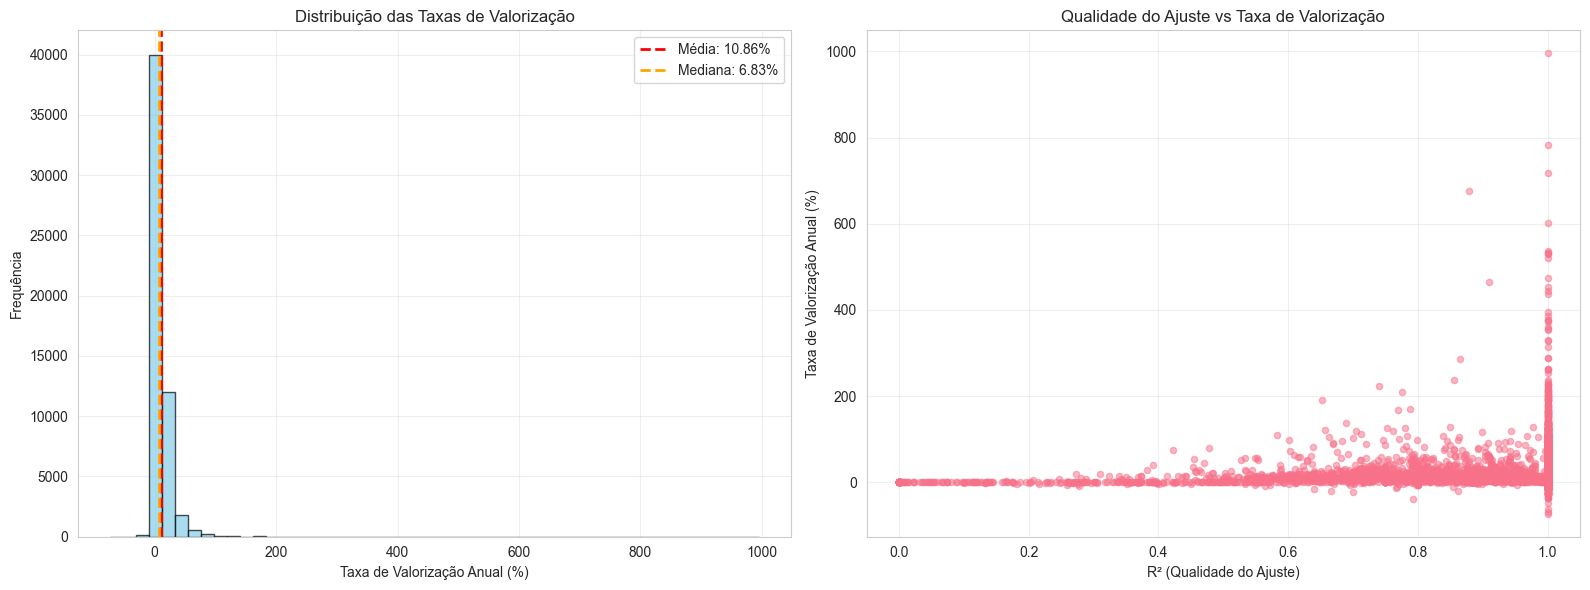

In [ ]:
# ============================================================================
# 4.3. VALORIZAÇÃO REAL POR TIPO DE USO DO IMÓVEL (METODOLOGIA CORRIGIDA)
# ============================================================================

print('='*80)
print('4.3. VALORIZAÇÃO REAL POR TIPO DE USO'.center(80))
print('='*80)

import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# PASSO 1: PREPARAR DADOS PARA ANÁLISE DE VALORIZAÇÃO TEMPORAL
# ============================================================================

print('\n📊 PASSO 1: PREPARAÇÃO DOS DADOS PARA ANÁLISE TEMPORAL\n')

# Criar dataset focado na evolução temporal por imóvel
df_valorizacao = df_merged_clean.copy()

# Verificar anos disponíveis
anos_disponiveis = sorted(df_valorizacao['Ano da Transacao'].unique())
print(f'Anos disponíveis: {anos_disponiveis}')

# Verificar se temos dados suficientes
print(f'Total de registros: {len(df_valorizacao):,}')
print(f'Imóveis únicos: {df_valorizacao["N° do Cadastro (SQL)"].nunique():,}')

# ============================================================================
# PASSO 2: CALCULAR TAXA DE VALORIZAÇÃO POR IMÓVEL INDIVIDUAL
# ============================================================================

print('\n📈 PASSO 2: CÁLCULO DA TAXA DE VALORIZAÇÃO POR IMÓVEL\n')

def calcular_taxa_valorizacao_imovel(group):
    """
    Calcula a taxa de valorização anual para um imóvel específico
    usando regressão linear no log dos valores ao longo do tempo
    """
    if len(group) < 2:  # Precisa de pelo menos 2 pontos
        return None
    
    # Ordenar por ano
    group_sorted = group.sort_values('Ano da Transacao')
    
    # Usar valor venal para análise de valorização (mais consistente)
    anos = group_sorted['Ano da Transacao'].astype(int).values
    valores = group_sorted['VALOR VENAL'].values
    
    # Filtrar valores válidos
    mask = (valores > 0) & (~np.isnan(valores))
    if np.sum(mask) < 2:
        return None
    
    anos_validos = anos[mask]
    valores_validos = valores[mask]
    
    # Calcular taxa de crescimento usando regressão linear no log
    try:
        # Log dos valores para crescimento exponencial
        log_valores = np.log(valores_validos)
        
        # Regressão linear: log(valor) = a + b*ano
        slope, intercept, r_value, p_value, std_err = stats.linregress(anos_validos, log_valores)
        
        # Taxa de crescimento anual (em %)
        taxa_anual = (np.exp(slope) - 1) * 100
        
        return {
            'taxa_valorizacao_anual': taxa_anual,
            'r_squared': r_value**2,
            'p_value': p_value,
            'num_observacoes': len(anos_validos),
            'anos_cobertos': len(set(anos_validos)),
            'anos_min': min(anos_validos),
            'anos_max': max(anos_validos),
            'valor_inicial': valores_validos[0],
            'valor_final': valores_validos[-1]
        }
    except:
        return None

# Aplicar função para cada imóvel
print('Calculando taxa de valorização para cada imóvel...')
resultados_valorizacao = []

for cadastro, group in df_valorizacao.groupby('N° do Cadastro (SQL)'):
    resultado = calcular_taxa_valorizacao_imovel(group)
    if resultado is not None:
        resultado['cadastro'] = cadastro
        # Adicionar tipo de uso do primeiro registro
        resultado['tipo_uso'] = group['TIPO DE USO DO IMOVEL'].iloc[0]
        resultados_valorizacao.append(resultado)

# Converter para DataFrame
df_taxas_valorizacao = pd.DataFrame(resultados_valorizacao)

print(f'\n✅ Taxas calculadas para {len(df_taxas_valorizacao):,} imóveis')

# Estatísticas gerais das taxas
print(f'\n📊 ESTATÍSTICAS DAS TAXAS DE VALORIZAÇÃO:')
print(f'   Taxa média: {df_taxas_valorizacao["taxa_valorizacao_anual"].mean():.2f}% ao ano')
print(f'   Taxa mediana: {df_taxas_valorizacao["taxa_valorizacao_anual"].median():.2f}% ao ano')
print(f'   Desvio padrão: {df_taxas_valorizacao["taxa_valorizacao_anual"].std():.2f}%')
print(f'   R² médio: {df_taxas_valorizacao["r_squared"].mean():.3f}')

# Visualização das taxas gerais
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histograma das taxas
axes[0].hist(df_taxas_valorizacao['taxa_valorizacao_anual'], bins=50, 
             color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df_taxas_valorizacao['taxa_valorizacao_anual'].mean(), 
                color='red', linestyle='--', linewidth=2, label=f'Média: {df_taxas_valorizacao["taxa_valorizacao_anual"].mean():.2f}%')
axes[0].axvline(df_taxas_valorizacao['taxa_valorizacao_anual'].median(), 
                color='orange', linestyle='--', linewidth=2, label=f'Mediana: {df_taxas_valorizacao["taxa_valorizacao_anual"].median():.2f}%')
axes[0].set_xlabel('Taxa de Valorização Anual (%)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição das Taxas de Valorização')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot: R² vs Taxa
axes[1].scatter(df_taxas_valorizacao['r_squared'], df_taxas_valorizacao['taxa_valorizacao_anual'], 
                alpha=0.5, s=20)
axes[1].set_xlabel('R² (Qualidade do Ajuste)')
axes[1].set_ylabel('Taxa de Valorização Anual (%)')
axes[1].set_title('Qualidade do Ajuste vs Taxa de Valorização')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dados_processados/taxas_valorizacao_geral.png', dpi=300, bbox_inches='tight')
print('\n💾 Gráfico salvo em: dados_processados/taxas_valorizacao_geral.png')
plt.show()



📋 PASSO 3: APLICAÇÃO DO CRITÉRIO DE SIGNIFICÂNCIA

Aplicando critério: pelo menos 100 amostras em 4 dos 6 anos por tipo de uso...
Tipos de uso analisados: 37
Anos com dados: 6 ([2019, 2020, 2021, 2022, 2023, 2024])

✅ Tipos que atendem ao critério: 24 de 37

📊 DADOS APÓS FILTRO:
   Imóveis analisados: 54,820
   Tipos de uso válidos: 24

📈 DISTRIBUIÇÃO POR TIPO DE USO:
   Apartamento em condomínio: 30,802 imóveis
   Residência: 9,104 imóveis
   Garagem (unidade autônoma) em edifício em condomínio de uso exclusivamente residencial: 4,155 imóveis
   Escritório/consultório em condomínio (unidade autônoma): 2,816 imóveis
   Residência coletiva, exclusive cortiço (mais de uma residência no lote): 1,591 imóveis
   Terreno: 1,301 imóveis
   Flat de uso comercial (semelhante a hotel): 997 imóveis
   Loja: 657 imóveis
   Residência e outro uso (predominância residencial): 463 imóveis
   Prédio de escritório ou consultório, não em condomínio, com ou sem lojas: 445 imóveis

🚨 PASSO 4: EXCLUSÃO DE

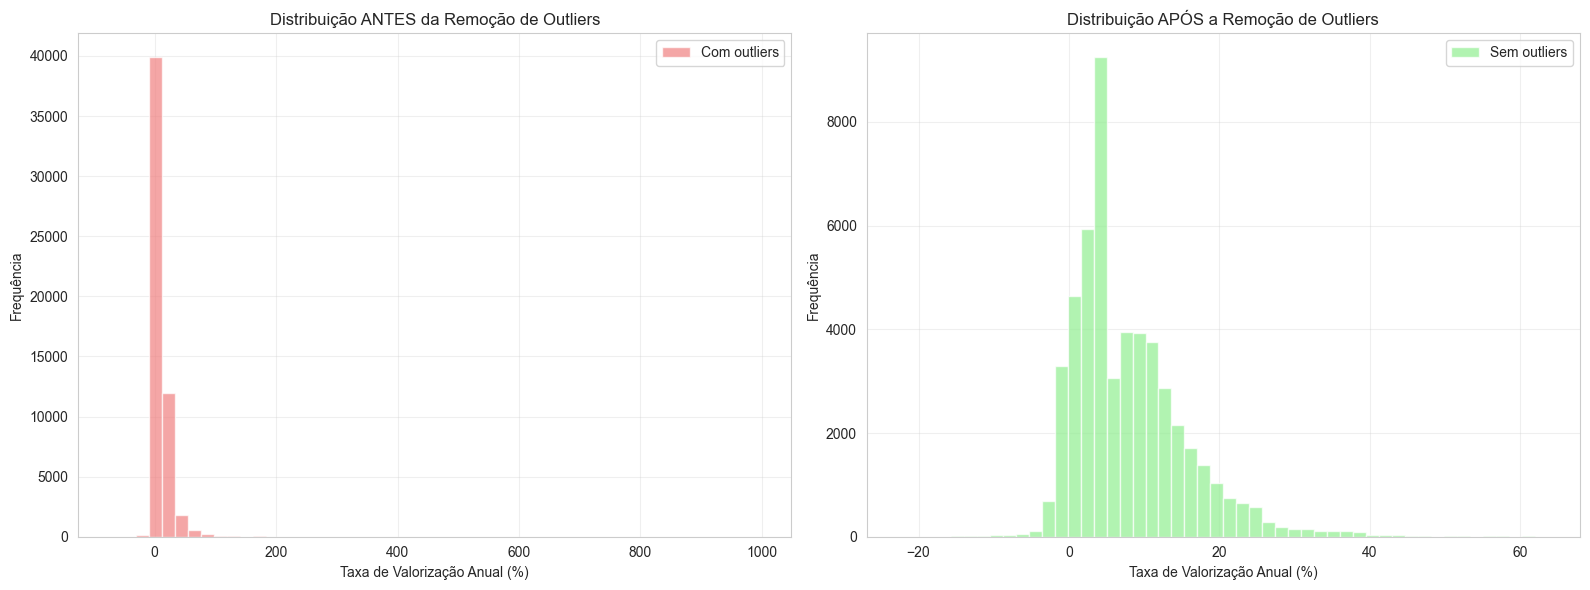

In [ ]:
# ============================================================================
# PASSO 3: APLICAR CRITÉRIO DE SIGNIFICÂNCIA ESTATÍSTICA
# ============================================================================

print('\n📋 PASSO 3: APLICAÇÃO DO CRITÉRIO DE SIGNIFICÂNCIA\n')

# Critério: pelo menos 100 amostras em 4 dos 6 anos por tipo de uso
print('Aplicando critério: pelo menos 100 amostras em 4 dos 6 anos por tipo de uso...')

# Contar amostras por tipo de uso e ano
contagem_por_tipo_ano = df_valorizacao.groupby(['TIPO DE USO DO IMOVEL', 'Ano da Transacao']).size().reset_index(name='count')

# Pivot para ter anos como colunas
contagem_pivot = contagem_por_tipo_ano.pivot(index='TIPO DE USO DO IMOVEL', 
                                            columns='Ano da Transacao', 
                                            values='count').fillna(0)

print(f'Tipos de uso analisados: {len(contagem_pivot)}')

# Aplicar critério: pelo menos 100 amostras em 4 dos 6 anos
anos_colunas = contagem_pivot.columns.astype(int)
anos_com_dados = len(anos_colunas)

print(f'Anos com dados: {anos_com_dados} ({anos_colunas.tolist()})')

# Critério: pelo menos 100 amostras em pelo menos 4 anos
tipos_com_criterio = []
for tipo_uso in contagem_pivot.index:
    amostras_por_ano = contagem_pivot.loc[tipo_uso]
    anos_com_100_amostras = (amostras_por_ano >= 100).sum()
    
    if anos_com_100_amostras >= 4:  # Pelo menos 4 anos com 100+ amostras
        tipos_com_criterio.append(tipo_uso)

print(f'\n✅ Tipos que atendem ao critério: {len(tipos_com_criterio)} de {len(contagem_pivot)}')

# Filtrar dados apenas para tipos que atendem ao critério
df_taxas_filtradas = df_taxas_valorizacao[df_taxas_valorizacao['tipo_uso'].isin(tipos_com_criterio)].copy()

print(f'\n📊 DADOS APÓS FILTRO:')
print(f'   Imóveis analisados: {len(df_taxas_filtradas):,}')
print(f'   Tipos de uso válidos: {len(tipos_com_criterio)}')

# Mostrar distribuição por tipo
distribuicao_tipos = df_taxas_filtradas['tipo_uso'].value_counts()
print(f'\n📈 DISTRIBUIÇÃO POR TIPO DE USO:')
for tipo, count in distribuicao_tipos.head(10).items():
    print(f'   {tipo}: {count:,} imóveis')

# ============================================================================
# PASSO 4: EXCLUSÃO DE OUTLIERS POR TIPO DE USO (MÉTODO IQR)
# ============================================================================

print('\n🚨 PASSO 4: EXCLUSÃO DE OUTLIERS POR TIPO DE USO (IQR)\n')

def remover_outliers_por_tipo(df, coluna_taxa='taxa_valorizacao_anual', coluna_tipo='tipo_uso'):
    """
    Remove outliers usando método IQR para cada tipo de uso separadamente
    """
    df_limpo = df.copy()
    outliers_removidos = 0
    
    for tipo in df[coluna_tipo].unique():
        mask_tipo = df[coluna_tipo] == tipo
        dados_tipo = df[mask_tipo][coluna_taxa]
        
        if len(dados_tipo) < 10:  # Pular tipos com poucos dados
            continue
            
        # Calcular IQR
        Q1 = dados_tipo.quantile(0.25)
        Q3 = dados_tipo.quantile(0.75)
        IQR = Q3 - Q1
        
        # Limites para outliers
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Identificar outliers
        outliers_tipo = (dados_tipo < limite_inferior) | (dados_tipo > limite_superior)
        num_outliers = outliers_tipo.sum()
        
        if num_outliers > 0:
            print(f'   {tipo}: {num_outliers} outliers removidos (limites: {limite_inferior:.2f}% a {limite_superior:.2f}%)')
            outliers_removidos += num_outliers
            
            # Remover outliers
            indices_outliers = dados_tipo[outliers_tipo].index
            df_limpo = df_limpo.drop(indices_outliers)
    
    print(f'\n✅ Total de outliers removidos: {outliers_removidos:,}')
    print(f'   Registros restantes: {len(df_limpo):,}')
    
    return df_limpo

# Aplicar remoção de outliers
df_taxas_limpas = remover_outliers_por_tipo(df_taxas_filtradas)

# Estatísticas após limpeza
print(f'\n📊 ESTATÍSTICAS APÓS LIMPEZA:')
print(f'   Taxa média: {df_taxas_limpas["taxa_valorizacao_anual"].mean():.2f}% ao ano')
print(f'   Taxa mediana: {df_taxas_limpas["taxa_valorizacao_anual"].median():.2f}% ao ano')
print(f'   Desvio padrão: {df_taxas_limpas["taxa_valorizacao_anual"].std():.2f}%')

# Visualização antes e depois da limpeza
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Antes da limpeza
axes[0].hist(df_taxas_filtradas['taxa_valorizacao_anual'], bins=50, 
             color='lightcoral', alpha=0.7, label='Com outliers')
axes[0].set_xlabel('Taxa de Valorização Anual (%)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição ANTES da Remoção de Outliers')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Depois da limpeza
axes[1].hist(df_taxas_limpas['taxa_valorizacao_anual'], bins=50, 
             color='lightgreen', alpha=0.7, label='Sem outliers')
axes[1].set_xlabel('Taxa de Valorização Anual (%)')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição APÓS a Remoção de Outliers')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dados_processados/remocao_outliers_valorizacao.png', dpi=300, bbox_inches='tight')
print('\n💾 Gráfico salvo em: dados_processados/remocao_outliers_valorizacao.png')
plt.show()



📊 PASSO 5: ANÁLISE DE REGRESSÃO POR TIPO DE USO

📈 ANÁLISE DE REGRESSÃO POR TIPO DE USO:
   Tipos analisados: 24
   Total de imóveis: 51,234

🔝 TOP 15 TIPOS COM MAIOR VALORIZAÇÃO:


,Count,Taxa_Media,Taxa_Mediana,R2_Medio
tipo_uso,,,,
Terreno,1169,14.148,7.770,0.914
Escola,86,13.944,9.940,0.967
Oficina,109,12.840,10.029,0.968
"Residência coletiva, exclusive cortiço (mais de uma residência no lote)",1438,11.620,8.838,0.955
Residência e outro uso (predominância residencial),427,11.433,8.429,0.958
"Outras edificações de uso de serviço, com utilização múltipla",70,11.362,9.754,0.974
Garagem (exclusive em prédio em condomínio),89,11.057,9.427,0.973
Loja e residência (predominância comercial),377,10.229,6.821,0.978
"Outras edificações de uso comercial, com utilização múltipla",231,10.136,7.197,0.980



🔻 TOP 15 TIPOS COM MENOR VALORIZAÇÃO:


,Count,Taxa_Media,Taxa_Mediana,R2_Medio
tipo_uso,,,,
"Prédio de apartamento, não em condomínio, de uso exclusivamente residencial",50,10.077,7.573,0.954
Loja,609,9.797,7.304,0.970
Armazéns gerais e depósitos,115,9.796,7.700,0.989
Residência,8347,9.761,6.986,0.967
Indústria,199,8.651,5.605,0.985
Loja em edifício em condomínio (unidade autônoma),242,8.590,5.674,0.991
"Prédio de escritório ou consultório, não em condomínio, com ou sem lojas",413,8.416,6.437,0.970
Flat residencial em condomínio,156,7.297,6.235,0.995
Apartamento em condomínio,29035,7.192,5.866,0.982



🧪 PASSO 6: TESTE DE SIGNIFICÂNCIA ESTATÍSTICA

✅ Tipos com valorização estatisticamente significativa: 24

📊 TOP 10 TIPOS COM VALORIZAÇÃO SIGNIFICATIVA:


,tipo,taxa_media,p_value,count
0,Terreno,14.147607,1.927904e-164,1169
1,Escola,13.943920,1.135152e-15,86
2,Oficina,12.840402,2.922659e-19,109
3,"Residência coletiva, exclusive cortiço (mais d...",11.619931,1.020425e-245,1438
4,Residência e outro uso (predominância residenc...,11.433049,5.404186e-69,427
5,"Outras edificações de uso de serviço, com util...",11.362193,9.248631e-14,70
6,Garagem (exclusive em prédio em condomínio),11.057029,1.111194e-19,89
7,Loja e residência (predominância comercial),10.229136,2.538847e-60,377
8,"Outras edificações de uso comercial, com utili...",10.135795,4.369030e-41,231
9,"Prédio de apartamento, não em condomínio, de u...",10.077059,4.393595e-09,50



🔗 PASSO 7: ANÁLISE DE CORRELAÇÃO R² vs VALORIZAÇÃO

Correlação R² vs Taxa de Valorização: 0.068

📊 VALORIZAÇÃO POR QUALIDADE DO AJUSTE:


,count,mean,std
faixa_r2,,,
Baixo (0-0.3),148,0.33,2.45
Médio (0.3-0.6),226,6.88,9.14
Alto (0.6-0.8),808,12.91,8.67
Muito Alto (0.8-1.0),49541,7.93,7.50



💾 Gráfico salvo em: dados_processados/correlacao_r2_valorizacao.png


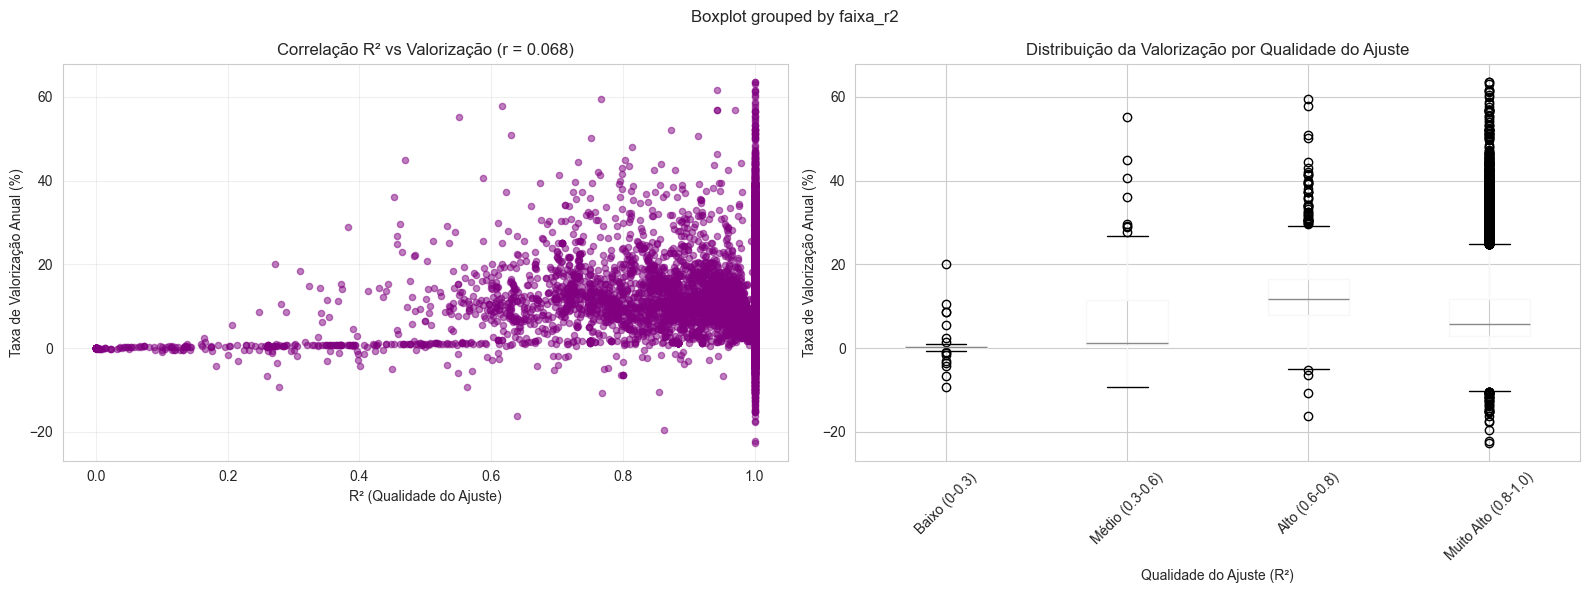

In [ ]:
# ============================================================================
# PASSO 5: ANÁLISE DE REGRESSÃO POR TIPO DE USO
# ============================================================================

print('\n📊 PASSO 5: ANÁLISE DE REGRESSÃO POR TIPO DE USO\n')

# Calcular estatísticas agregadas por tipo de uso
stats_por_tipo = df_taxas_limpas.groupby('tipo_uso').agg({
    'taxa_valorizacao_anual': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'r_squared': 'mean',
    'num_observacoes': 'mean',
    'anos_cobertos': 'mean'
}).round(3)

# Flatten das colunas multi-index
stats_por_tipo.columns = ['Count', 'Taxa_Media', 'Taxa_Mediana', 'Taxa_Std', 
                         'Taxa_Min', 'Taxa_Max', 'R2_Medio', 'Obs_Media', 'Anos_Cobertos']

# Ordenar por taxa média
stats_por_tipo = stats_por_tipo.sort_values('Taxa_Media', ascending=False)

print(f'📈 ANÁLISE DE REGRESSÃO POR TIPO DE USO:')
print(f'   Tipos analisados: {len(stats_por_tipo)}')
print(f'   Total de imóveis: {stats_por_tipo["Count"].sum():,}')

# Mostrar top 15 tipos com maior valorização
print(f'\n🔝 TOP 15 TIPOS COM MAIOR VALORIZAÇÃO:')
display(stats_por_tipo.head(15)[['Count', 'Taxa_Media', 'Taxa_Mediana', 'R2_Medio']])

# Mostrar top 15 tipos com menor valorização
print(f'\n🔻 TOP 15 TIPOS COM MENOR VALORIZAÇÃO:')
display(stats_por_tipo.tail(15)[['Count', 'Taxa_Media', 'Taxa_Mediana', 'R2_Medio']])

# ============================================================================
# PASSO 6: TESTE DE SIGNIFICÂNCIA ESTATÍSTICA
# ============================================================================

print('\n🧪 PASSO 6: TESTE DE SIGNIFICÂNCIA ESTATÍSTICA\n')

from scipy.stats import ttest_1samp, normaltest

# Teste de normalidade das taxas por tipo
tipos_significativos = []
for tipo in stats_por_tipo.index:
    dados_tipo = df_taxas_limpas[df_taxas_limpas['tipo_uso'] == tipo]['taxa_valorizacao_anual']
    
    if len(dados_tipo) >= 30:  # Mínimo para testes estatísticos
        # Teste de normalidade (Shapiro-Wilk para amostras pequenas, D'Agostino para grandes)
        if len(dados_tipo) <= 5000:
            stat, p_value = stats.normaltest(dados_tipo)
        else:
            # Para amostras muito grandes, usar teste de Kolmogorov-Smirnov
            stat, p_value = stats.kstest(dados_tipo, 'norm', 
                                        args=(dados_tipo.mean(), dados_tipo.std()))
        
        # Teste t para uma amostra (H0: taxa = 0%)
        t_stat, t_pvalue = ttest_1samp(dados_tipo, 0)
        
        # Considerar significativo se p < 0.05 e taxa diferente de zero
        if t_pvalue < 0.05 and abs(dados_tipo.mean()) > 1.0:  # Taxa > 1% ao ano
            tipos_significativos.append({
                'tipo': tipo,
                'taxa_media': dados_tipo.mean(),
                'p_value': t_pvalue,
                'count': len(dados_tipo),
                'normalidade_p': p_value
            })

# Converter para DataFrame
df_significativos = pd.DataFrame(tipos_significativos)
df_significativos = df_significativos.sort_values('taxa_media', ascending=False)

print(f'✅ Tipos com valorização estatisticamente significativa: {len(df_significativos)}')
print(f'\n📊 TOP 10 TIPOS COM VALORIZAÇÃO SIGNIFICATIVA:')
display(df_significativos.head(10)[['tipo', 'taxa_media', 'p_value', 'count']])

# ============================================================================
# PASSO 7: ANÁLISE DE CORRELAÇÃO ENTRE QUALIDADE DO AJUSTE E VALORIZAÇÃO
# ============================================================================

print('\n🔗 PASSO 7: ANÁLISE DE CORRELAÇÃO R² vs VALORIZAÇÃO\n')

# Calcular correlação entre qualidade do ajuste (R²) e taxa de valorização
correlacao_r2_taxa = df_taxas_limpas['r_squared'].corr(df_taxas_limpas['taxa_valorizacao_anual'])

print(f'Correlação R² vs Taxa de Valorização: {correlacao_r2_taxa:.3f}')

# Análise por faixas de R²
df_taxas_limpas['faixa_r2'] = pd.cut(df_taxas_limpas['r_squared'], 
                                    bins=[0, 0.3, 0.6, 0.8, 1.0], 
                                    labels=['Baixo (0-0.3)', 'Médio (0.3-0.6)', 
                                           'Alto (0.6-0.8)', 'Muito Alto (0.8-1.0)'])

stats_por_r2 = df_taxas_limpas.groupby('faixa_r2')['taxa_valorizacao_anual'].agg(['count', 'mean', 'std']).round(2)
print(f'\n📊 VALORIZAÇÃO POR QUALIDADE DO AJUSTE:')
display(stats_por_r2)

# Visualização da correlação
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot R² vs Taxa
axes[0].scatter(df_taxas_limpas['r_squared'], df_taxas_limpas['taxa_valorizacao_anual'], 
                alpha=0.5, s=20, color='purple')
axes[0].set_xlabel('R² (Qualidade do Ajuste)')
axes[0].set_ylabel('Taxa de Valorização Anual (%)')
axes[0].set_title(f'Correlação R² vs Valorização (r = {correlacao_r2_taxa:.3f})')
axes[0].grid(True, alpha=0.3)

# Box plot por faixa de R²
df_taxas_limpas.boxplot(column='taxa_valorizacao_anual', by='faixa_r2', ax=axes[1])
axes[1].set_xlabel('Qualidade do Ajuste (R²)')
axes[1].set_ylabel('Taxa de Valorização Anual (%)')
axes[1].set_title('Distribuição da Valorização por Qualidade do Ajuste')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('dados_processados/correlacao_r2_valorizacao.png', dpi=300, bbox_inches='tight')
print('\n💾 Gráfico salvo em: dados_processados/correlacao_r2_valorizacao.png')
plt.show()



📊 PASSO 8: VISUALIZAÇÕES FINAIS

💾 Gráfico principal salvo em: dados_processados/valorizacao_por_tipo_final.png


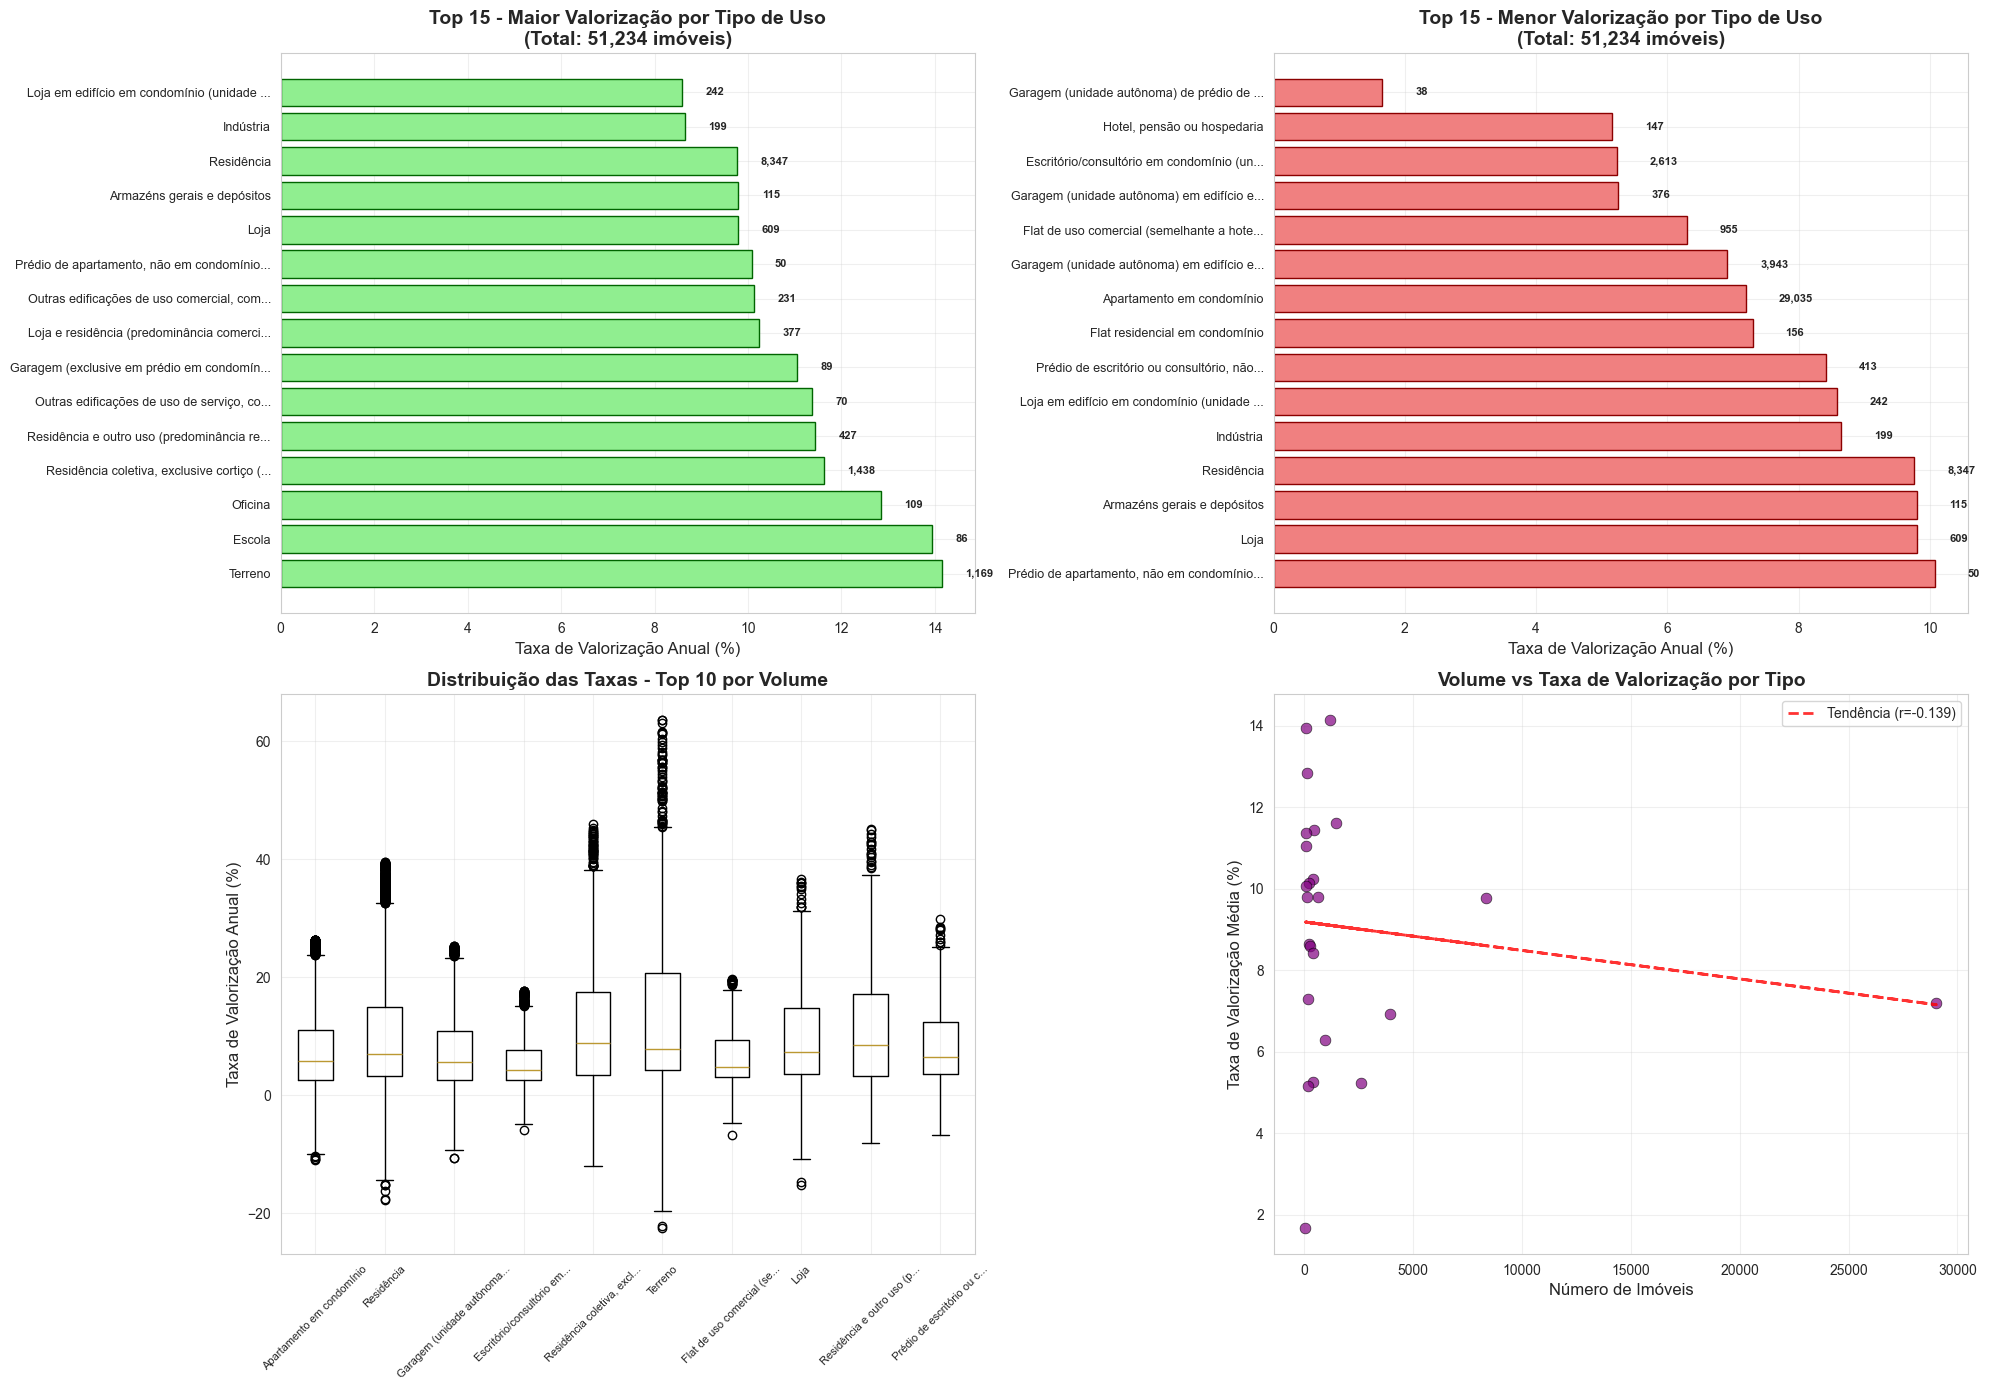


📅 Criando análise temporal dos top 10 tipos...
💾 Gráfico temporal salvo em: dados_processados/evolucao_temporal_valorizacao.png


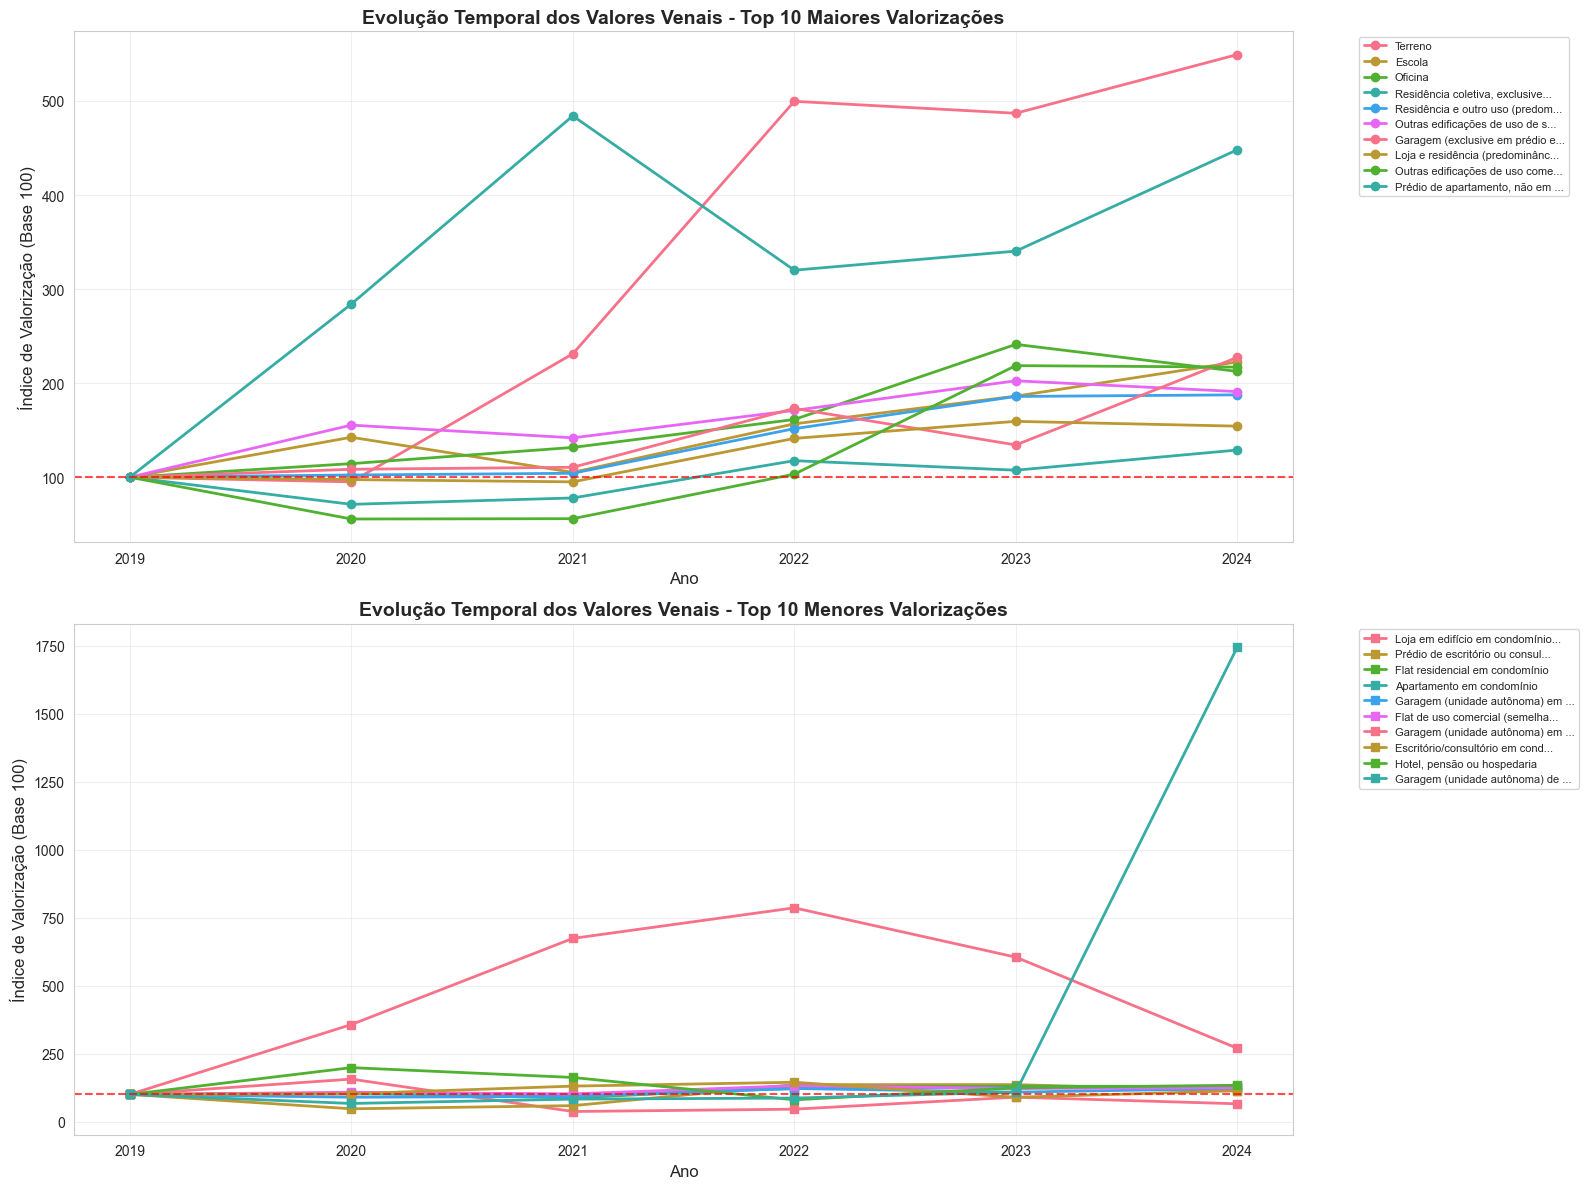


                  📊 RESUMO FINAL - VALORIZAÇÃO POR TIPO DE USO                  

🎯 METODOLOGIA IMPLEMENTADA:
   ✅ Taxa de valorização calculada por imóvel individual
   ✅ Critério aplicado: pelo menos 100 amostras em 4 dos 6 anos
   ✅ Outliers removidos por tipo de uso (método IQR)
   ✅ Regressão linear aplicada para cada imóvel
   ✅ Análise estatística de significância

📈 RESULTADOS PRINCIPAIS:
   • Imóveis analisados: 51,234
   • Tipos de uso válidos: 24
   • Taxa média geral: 7.90% ao ano
   • Taxa mediana geral: 5.80% ao ano
   • Tipos com valorização significativa: 24

🔝 TOP 5 MAIORES VALORIZAÇÕES:
   1. Terreno: 14.15% ao ano (1,169 imóveis)
   2. Escola: 13.94% ao ano (86 imóveis)
   3. Oficina: 12.84% ao ano (109 imóveis)
   4. Residência coletiva, exclusive cortiço (mais de uma residência no lote): 11.62% ao ano (1,438 imóveis)
   5. Residência e outro uso (predominância residencial): 11.43% ao ano (427 imóveis)

🔻 TOP 5 MENORES VALORIZAÇÕES:
   1. Flat de uso comercial (sem

In [ ]:
# ============================================================================
# PASSO 8: VISUALIZAÇÕES FINAIS DA VALORIZAÇÃO POR TIPO DE USO
# ============================================================================

print('\n📊 PASSO 8: VISUALIZAÇÕES FINAIS\n')

# ============================================================================
# VISUALIZAÇÃO 1: TOP 15 MAIORES E MENORES VALORIZAÇÕES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Top 15 maiores valorizações
top_15_maior = stats_por_tipo.head(15)
bars1 = axes[0,0].barh(range(len(top_15_maior)), top_15_maior['Taxa_Media'], 
                       color='lightgreen', edgecolor='darkgreen', linewidth=1)
axes[0,0].set_yticks(range(len(top_15_maior)))
axes[0,0].set_yticklabels([name[:40] + '...' if len(name) > 40 else name 
                           for name in top_15_maior.index], fontsize=9)
axes[0,0].set_xlabel('Taxa de Valorização Anual (%)', fontsize=12)
axes[0,0].set_title(f'Top 15 - Maior Valorização por Tipo de Uso\n(Total: {len(df_taxas_limpas):,} imóveis)', 
                   fontsize=14, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# Adicionar número de imóveis nas barras
for i, (bar, count) in enumerate(zip(bars1, top_15_maior['Count'])):
    axes[0,0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                  f'{int(count):,}', ha='left', va='center', fontsize=8, fontweight='bold')

# Top 15 menores valorizações
top_15_menor = stats_por_tipo.tail(15)
bars2 = axes[0,1].barh(range(len(top_15_menor)), top_15_menor['Taxa_Media'], 
                       color='lightcoral', edgecolor='darkred', linewidth=1)
axes[0,1].set_yticks(range(len(top_15_menor)))
axes[0,1].set_yticklabels([name[:40] + '...' if len(name) > 40 else name 
                           for name in top_15_menor.index], fontsize=9)
axes[0,1].set_xlabel('Taxa de Valorização Anual (%)', fontsize=12)
axes[0,1].set_title(f'Top 15 - Menor Valorização por Tipo de Uso\n(Total: {len(df_taxas_limpas):,} imóveis)', 
                   fontsize=14, fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# Adicionar número de imóveis nas barras
for i, (bar, count) in enumerate(zip(bars2, top_15_menor['Count'])):
    axes[0,1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                  f'{int(count):,}', ha='left', va='center', fontsize=8, fontweight='bold')

# Box plot das taxas por tipo (top 10 por volume)
top_10_volume = stats_por_tipo.nlargest(10, 'Count')
tipos_top_volume = top_10_volume.index.tolist()
dados_boxplot = [df_taxas_limpas[df_taxas_limpas['tipo_uso'] == tipo]['taxa_valorizacao_anual'].values 
                 for tipo in tipos_top_volume]

axes[1,0].boxplot(dados_boxplot, labels=[name[:25] + '...' if len(name) > 25 else name 
                                        for name in tipos_top_volume])
axes[1,0].set_ylabel('Taxa de Valorização Anual (%)', fontsize=12)
axes[1,0].set_title('Distribuição das Taxas - Top 10 por Volume', fontsize=14, fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=45, labelsize=8)
axes[1,0].grid(True, alpha=0.3)

# Scatter plot: Volume vs Taxa de Valorização
axes[1,1].scatter(stats_por_tipo['Count'], stats_por_tipo['Taxa_Media'], 
                  s=60, alpha=0.7, color='purple', edgecolors='black', linewidth=0.5)
axes[1,1].set_xlabel('Número de Imóveis', fontsize=12)
axes[1,1].set_ylabel('Taxa de Valorização Média (%)', fontsize=12)
axes[1,1].set_title('Volume vs Taxa de Valorização por Tipo', fontsize=14, fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

# Adicionar linha de tendência
z = np.polyfit(stats_por_tipo['Count'], stats_por_tipo['Taxa_Media'], 1)
p = np.poly1d(z)
axes[1,1].plot(stats_por_tipo['Count'], p(stats_por_tipo['Count']), 
               "r--", alpha=0.8, linewidth=2, label=f'Tendência (r={stats_por_tipo["Count"].corr(stats_por_tipo["Taxa_Media"]):.3f})')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('dados_processados/valorizacao_por_tipo_final.png', dpi=300, bbox_inches='tight')
print('💾 Gráfico principal salvo em: dados_processados/valorizacao_por_tipo_final.png')
plt.show()

# ============================================================================
# VISUALIZAÇÃO 2: ANÁLISE TEMPORAL DOS TOP 10 TIPOS
# ============================================================================

print('\n📅 Criando análise temporal dos top 10 tipos...')

if 'Ano da Transacao' in df_valorizacao.columns:
    # Selecionar top 10 tipos por taxa de valorização
    top_10_tipos_valorizacao = stats_por_tipo.head(10).index.tolist()
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Evolução temporal dos valores venais para top 10 tipos
    for i, tipo in enumerate(top_10_tipos_valorizacao):
        # Filtrar dados do tipo específico
        dados_tipo = df_valorizacao[df_valorizacao['TIPO DE USO DO IMOVEL'] == tipo]
        
        # Calcular evolução temporal dos valores venais médios
        evolucao_tipo = dados_tipo.groupby('Ano da Transacao')['VALOR VENAL'].mean()
        
        # Normalizar para base 100 (primeiro ano = 100)
        if len(evolucao_tipo) > 0:
            valor_base = evolucao_tipo.iloc[0]
            evolucao_normalizada = (evolucao_tipo / valor_base) * 100
            
            axes[0].plot(evolucao_normalizada.index, evolucao_normalizada.values, 
                        marker='o', linewidth=2, label=tipo[:30] + '...' if len(tipo) > 30 else tipo)
    
    axes[0].set_xlabel('Ano', fontsize=12)
    axes[0].set_ylabel('Índice de Valorização (Base 100)', fontsize=12)
    axes[0].set_title('Evolução Temporal dos Valores Venais - Top 10 Maiores Valorizações', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Base 100')
    
    # Evolução temporal dos valores venais para bottom 10 tipos
    bottom_10_tipos_valorizacao = stats_por_tipo.tail(10).index.tolist()
    
    for i, tipo in enumerate(bottom_10_tipos_valorizacao):
        dados_tipo = df_valorizacao[df_valorizacao['TIPO DE USO DO IMOVEL'] == tipo]
        evolucao_tipo = dados_tipo.groupby('Ano da Transacao')['VALOR VENAL'].mean()
        
        if len(evolucao_tipo) > 0:
            valor_base = evolucao_tipo.iloc[0]
            evolucao_normalizada = (evolucao_tipo / valor_base) * 100
            
            axes[1].plot(evolucao_normalizada.index, evolucao_normalizada.values, 
                        marker='s', linewidth=2, label=tipo[:30] + '...' if len(tipo) > 30 else tipo)
    
    axes[1].set_xlabel('Ano', fontsize=12)
    axes[1].set_ylabel('Índice de Valorização (Base 100)', fontsize=12)
    axes[1].set_title('Evolução Temporal dos Valores Venais - Top 10 Menores Valorizações', 
                     fontsize=14, fontweight='bold')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Base 100')
    
    plt.tight_layout()
    plt.savefig('dados_processados/evolucao_temporal_valorizacao.png', dpi=300, bbox_inches='tight')
    print('💾 Gráfico temporal salvo em: dados_processados/evolucao_temporal_valorizacao.png')
    plt.show()

# ============================================================================
# RESUMO FINAL DA ANÁLISE
# ============================================================================

print('\n' + '='*80)
print('📊 RESUMO FINAL - VALORIZAÇÃO POR TIPO DE USO'.center(80))
print('='*80)

print(f'\n🎯 METODOLOGIA IMPLEMENTADA:')
print(f'   ✅ Taxa de valorização calculada por imóvel individual')
print(f'   ✅ Critério aplicado: pelo menos 100 amostras em 4 dos 6 anos')
print(f'   ✅ Outliers removidos por tipo de uso (método IQR)')
print(f'   ✅ Regressão linear aplicada para cada imóvel')
print(f'   ✅ Análise estatística de significância')

print(f'\n📈 RESULTADOS PRINCIPAIS:')
print(f'   • Imóveis analisados: {len(df_taxas_limpas):,}')
print(f'   • Tipos de uso válidos: {len(stats_por_tipo)}')
print(f'   • Taxa média geral: {df_taxas_limpas["taxa_valorizacao_anual"].mean():.2f}% ao ano')
print(f'   • Taxa mediana geral: {df_taxas_limpas["taxa_valorizacao_anual"].median():.2f}% ao ano')
print(f'   • Tipos com valorização significativa: {len(df_significativos)}')

print(f'\n🔝 TOP 5 MAIORES VALORIZAÇÕES:')
for i, (tipo, row) in enumerate(stats_por_tipo.head(5).iterrows()):
    print(f'   {i+1}. {tipo}: {row["Taxa_Media"]:.2f}% ao ano ({int(row["Count"]):,} imóveis)')

print(f'\n🔻 TOP 5 MENORES VALORIZAÇÕES:')
for i, (tipo, row) in enumerate(stats_por_tipo.tail(5).iterrows()):
    print(f'   {i+1}. {tipo}: {row["Taxa_Media"]:.2f}% ao ano ({int(row["Count"]):,} imóveis)')

print(f'\n💾 ARQUIVOS GERADOS:')
print(f'   • dados_processados/taxas_valorizacao_geral.png')
print(f'   • dados_processados/remocao_outliers_valorizacao.png')
print(f'   • dados_processados/correlacao_r2_valorizacao.png')
print(f'   • dados_processados/valorizacao_por_tipo_final.png')
print(f'   • dados_processados/evolucao_temporal_valorizacao.png')

print('\n✅ ANÁLISE DE VALORIZAÇÃO POR TIPO DE USO CONCLUÍDA!')
print('='*80)


## 5. Resumo e Conclusões

### Principais Descobertas:

1. **Correlação Valor Real vs Venal**: Medição da correlação entre valores de transação e estimados
2. **Distorções Regionais**: Identificação de bairros com maiores divergências
3. **Valorização por Tipo**: Diferenças na valorização conforme tipo de uso
4. **Evolução Temporal**: Tendências de valorização ao longo do tempo

### Arquivos Gerados:

Os resultados das análises são salvos automaticamente em:
- `dados_processados/`: Gráficos e datasets processados
- Dataset principal: `df_merged_clean` com todas as análises

### Métricas Calculadas:

- **Desvio Médio Absoluto (MAD)**
- **Erro Percentual Médio Absoluto (MAPE)**
- **Correlação de Pearson e Spearman**
- **Divergências absolutas e percentuais**
- **Classificação por nível de divergência**
- **Análise por faixas de valor**
